In [120]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize
from matplotlib import image as mpimg
import cv2


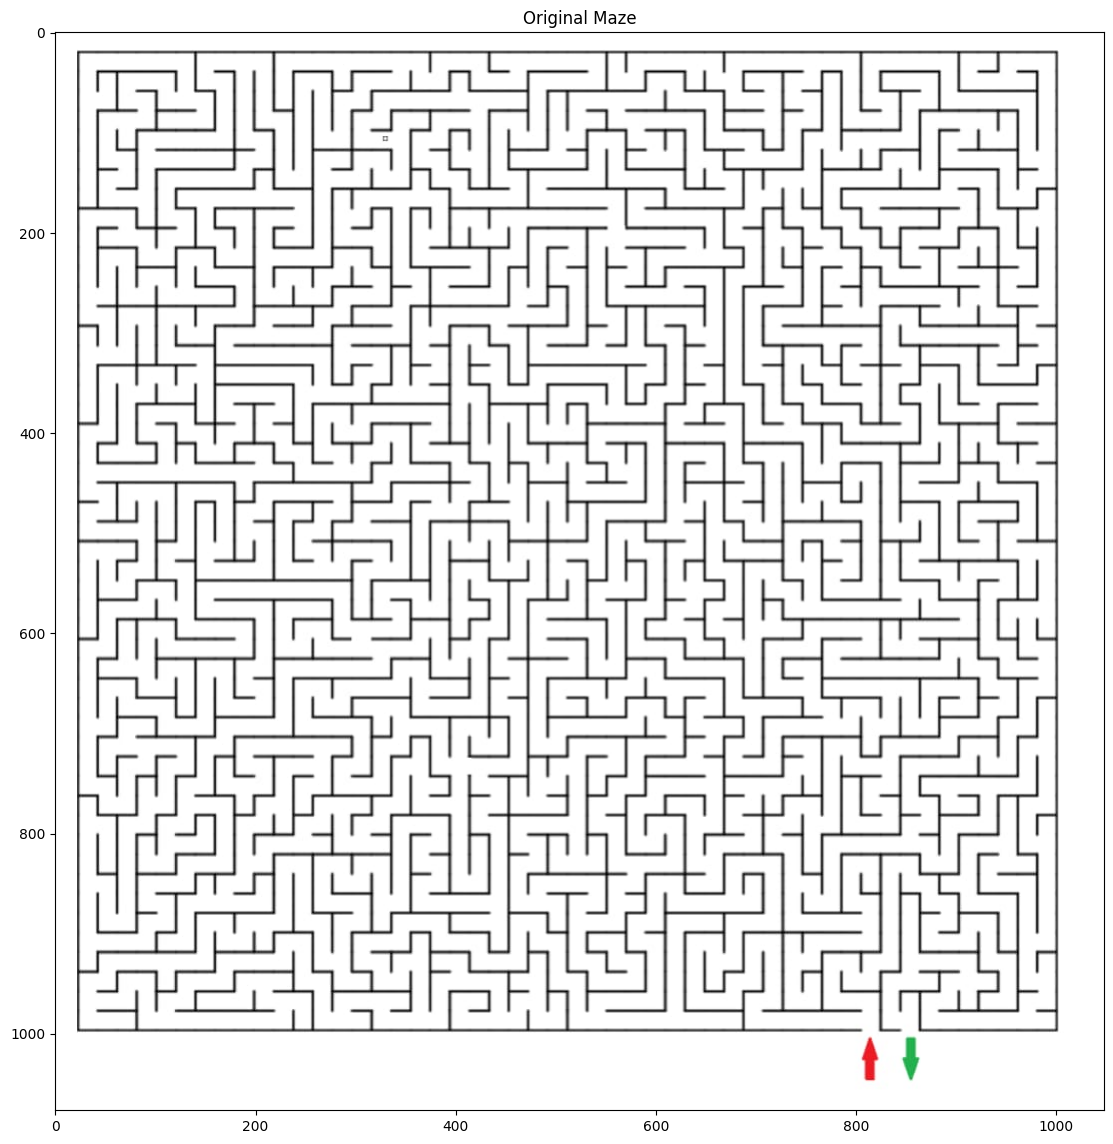

In [121]:
# Read the image
img_name = 'maze.jpg'
rgb_img = plt.imread(img_name)

plt.figure(figsize=(14,14))
plt.title("Original Maze")
plt.imshow(rgb_img)
plt.show()


In [122]:

# Convert to grayscale
gray_img = cv2.cvtColor(rgb_img.astype(np.uint8), cv2.COLOR_RGB2GRAY)


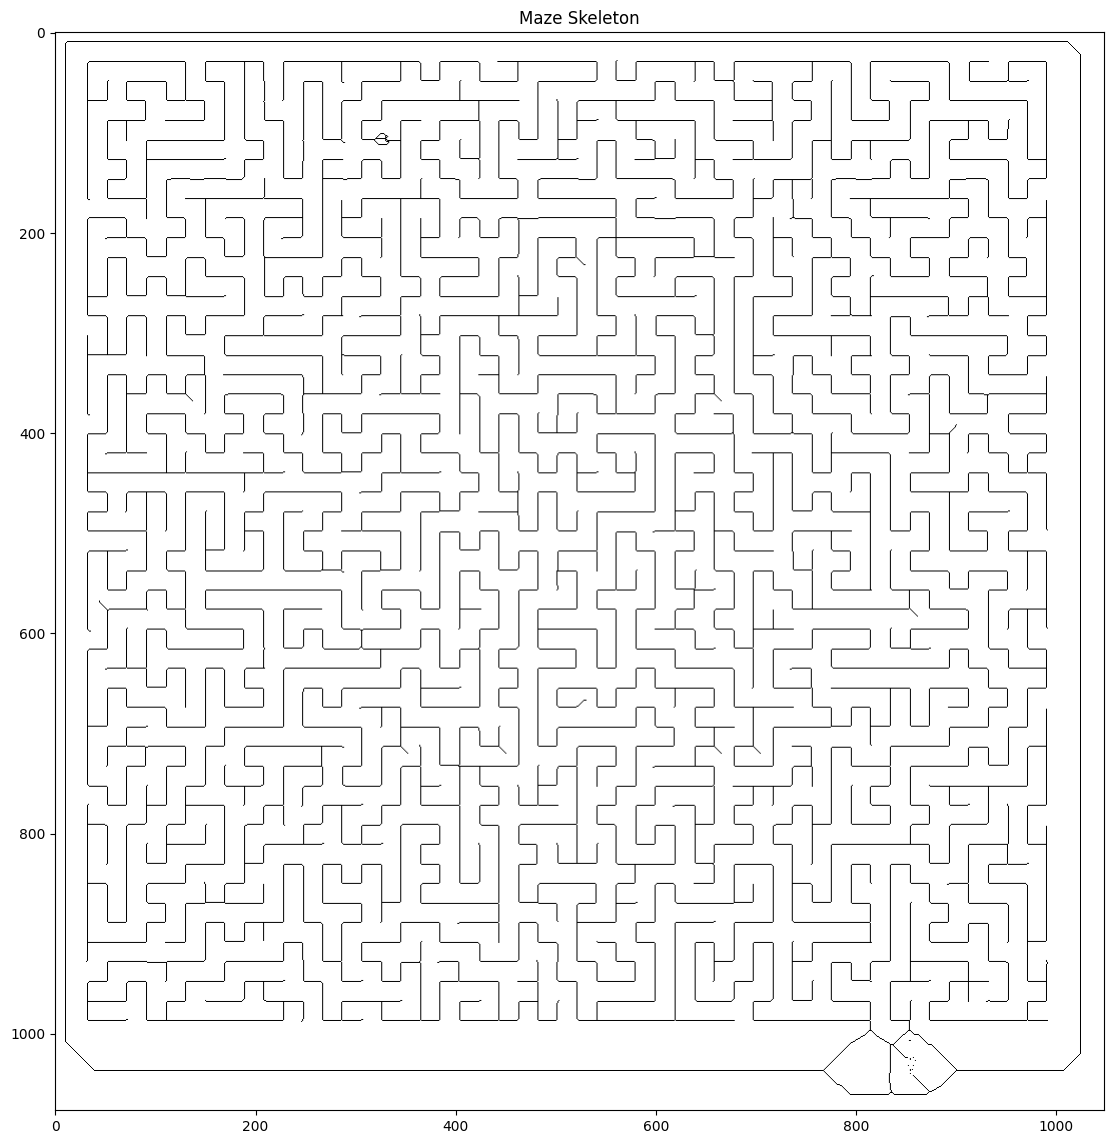

In [123]:
# Apply threshold
_, thr_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)

# Create skeleton
skeleton = skeletonize(thr_img > 0)
mapT = ~skeleton

plt.figure(figsize=(14,14))
plt.title("Maze Skeleton")
plt.imshow(mapT, cmap='gray')
plt.show()


In [124]:

def find_path(mapT, start_point, end_point, box_radius=30):
    """Find the path through the maze using BFS."""
    _mapt = np.copy(mapT)
    x1, y1 = end_point
    x0, y0 = start_point
    
    # Find closest path points to start and end
    start_y, start_x = np.where(_mapt[y0-box_radius:y0+box_radius, 
                                    x0-box_radius:x0+box_radius]==0)
    start_y += y0-box_radius
    start_x += x0-box_radius
    start_idx = np.argmin(np.sqrt((start_y-y0)**2 + (start_x-x0)**2))
    start_y, start_x = start_y[start_idx], start_x[start_idx]
    
    end_y, end_x = np.where(_mapt[y1-box_radius:y1+box_radius, 
                                x1-box_radius:x1+box_radius]==0)
    end_y += y1-box_radius
    end_x += x1-box_radius
    end_idx = np.argmin(np.sqrt((end_y-y1)**2 + (end_x-x1)**2))
    end_y, end_x = end_y[end_idx], end_x[end_idx]
    
    # Initialize BFS
    pts_x = [start_x]
    pts_y = [start_y]
    pts_c = [0]
    xmesh, ymesh = np.meshgrid(np.arange(-1,2), np.arange(-1,2))
    ymesh = ymesh.reshape(-1)
    xmesh = xmesh.reshape(-1)
    dst = np.zeros(mapT.shape)
    
    # BFS algorithm
    while True:
        if not pts_x:
            print("No path found!")
            return [], []
        
        idc = np.argmin(pts_c)
        ct = pts_c.pop(idc)
        x = pts_x.pop(idc)
        y = pts_y.pop(idc)
        
        ys, xs = np.where(_mapt[y-1:y+2, x-1:x+2] == 0)
        _mapt[ys+y-1, xs+x-1] = ct
        _mapt[y,x] = 9999999
        dst[ys+y-1, xs+x-1] = ct+1
        
        for new_x, new_y in zip(xs+x-1, ys+y-1):
            if 0 <= new_x < 1000 and 0 <= new_y < 1000:
                pts_x.append(new_x)
                pts_y.append(new_y)
                pts_c.append(ct+1)
        
        if np.sqrt((x-end_x)**2 + (y-end_y)**2) < 2:
            break
    
    # Trace path
    path_x = [end_x]
    path_y = [end_y]
    y, x = end_y, end_x
    
    while True:
        nbh = dst[y-1:y+2, x-1:x+2]
        nbh[1,1] = 9999999
        nbh[nbh==0] = 9999999
        
        if np.min(nbh) == 9999999:
            break
            
        idx = np.argmin(nbh)
        y += ymesh[idx]
        x += xmesh[idx]
        
        # Ensure the path stays within the bounds
        if x < 0 or x > 1000 or y < 0 or y > 1000:
            continue
        
        path_y.append(y)
        path_x.append(x)
        
        if np.sqrt((x-start_x)**2 + (y-start_y)**2) < 2:
            print('Path found!')
            break
            
    return path_x, path_y, (start_x, start_y), (end_x, end_y)



In [125]:
# Define start and end points (from your arrows)
start_point = (855, 1000)  # x, y coordinates
end_point = (810, 1000)    # x, y coordinates


Path found!


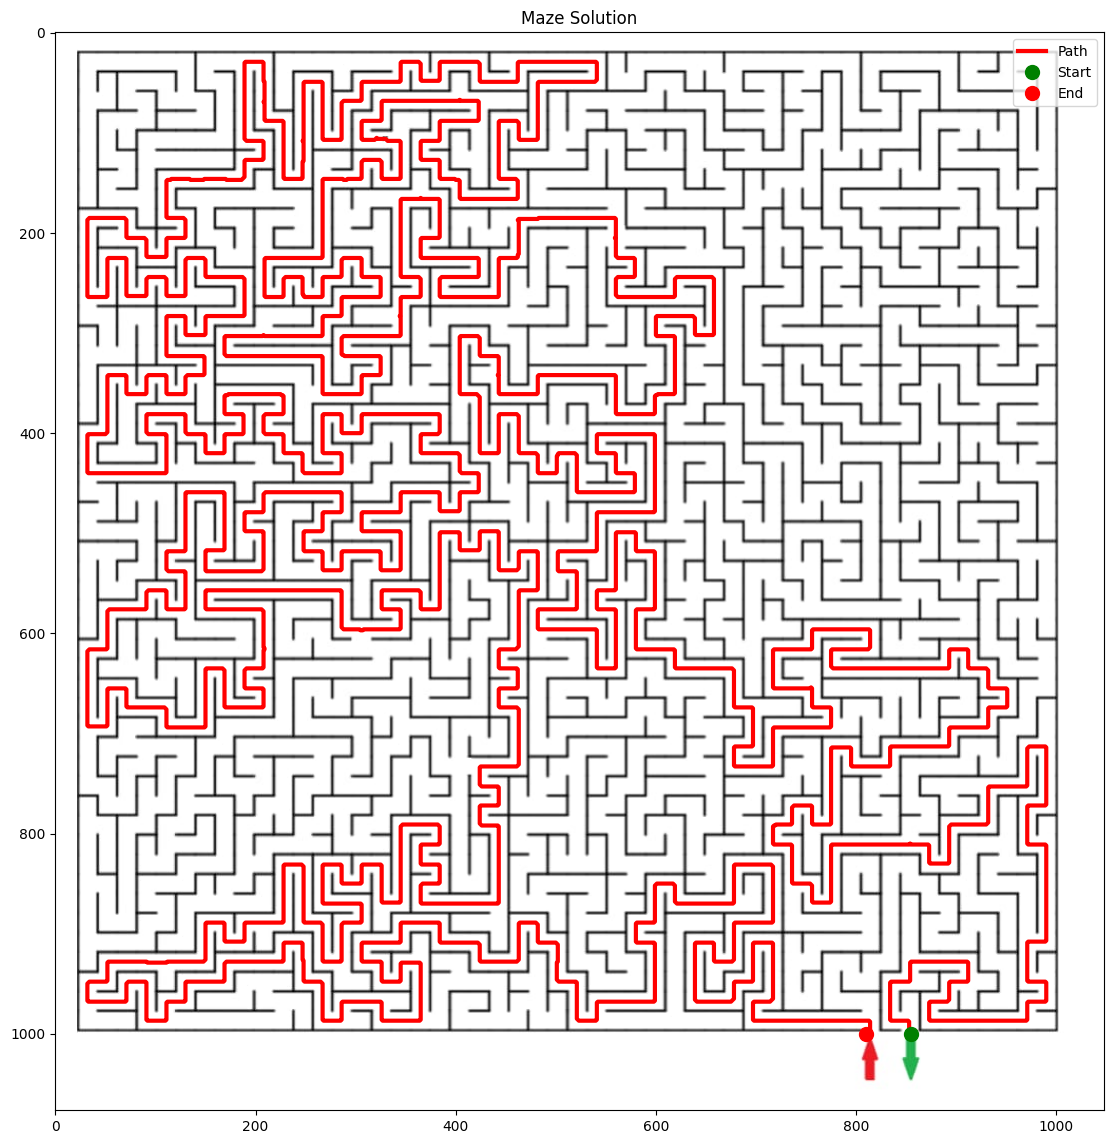

In [126]:
# Find path
path_x, path_y, start_maze, end_maze = find_path(mapT, start_point, end_point)

if path_x and path_y:
    # Create final visualization
    plt.figure(figsize=(14,14))
    plt.imshow(rgb_img)
    
    # Draw the path as a thick red line
    plt.plot(path_x, path_y, 'r-', linewidth=3, label='Path')
    
    # Mark start and end points
    plt.plot(start_point[0], start_point[1], 'go', markersize=10, label='Start')
    plt.plot(end_point[0], end_point[1], 'ro', markersize=10, label='End')
    
    plt.title("Maze Solution")
    plt.legend()
    plt.show()